In [1]:
import os 
import timm
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [2]:
from multissl.models import MSRGBConvNeXtUPerNetMixed
from multissl.data.seg_transforms import JointTransform, ValidationJointTransform
from multissl.data.semantic_partial_dataset import MixedSupervisionSegmentationDataset, mixed_supervision_collate_fn

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from typing import Dict, Any, List, Optional
import os

def plot_mixed_supervision_batch(
    batch: Dict[str, Any],
    num_samples: int = 8,
    save_path: Optional[str] = None,
    class_names: Optional[List[str]] = None,
    ignore_index: int = 255,
    figsize: tuple = (16, 12)
) -> plt.Figure:
    """
    Plot a batch from MixedSupervisionSegmentationDataset showing images, masks, and supervision types.
    
    Args:
        batch: Batch dictionary from the dataset
        num_samples: Number of samples to plot (max)
        save_path: Optional path to save the figure
        class_names: Optional list of class names for legend
        ignore_index: Value used for ignored/unlabeled pixels
        figsize: Figure size tuple
        
    Returns:
        matplotlib Figure object
    """
    # Extract data from batch
    images = batch['images']  # [B, C, H, W]
    masks = batch['masks']    # [B, H, W]
    supervision_types = batch['supervision_types']
    image_paths = batch.get('image_paths', [])
    
    # Limit number of samples
    batch_size = images.shape[0]
    num_samples = min(num_samples, batch_size)
    
    # Create figure with subplots
    fig, axes = plt.subplots(3, num_samples, figsize=figsize)
    if num_samples == 1:
        axes = axes.reshape(3, 1)
    
    # Set up colormap for masks
    if class_names is None:
        class_names = [f'Class {i}' for i in range(int(masks.max().item()) + 1)]
    
    # Create colormap for visualization
    colors = plt.cm.Set3(np.linspace(0, 1, len(class_names)))
    
    for i in range(num_samples):
        # Get image and mask
        image = images[i]  # [C, H, W]
        mask = masks[i]    # [H, W]
        supervision_type = supervision_types[i]
        
        # Convert image to displayable format
        img_display = tensor_to_displayable_image(image)
        
        # Convert mask to numpy
        mask_np = mask.cpu().numpy() if isinstance(mask, torch.Tensor) else mask
        
        # Create mask visualization
        mask_display = create_mask_visualization(mask_np, colors, ignore_index)
        
        # Plot original image
        axes[0, i].imshow(img_display)
        axes[0, i].set_title(f'Image {i+1}\n{supervision_type.title()} Supervision', 
                            fontsize=10, pad=10)
        axes[0, i].axis('off')
        
        # Add supervision type indicator
        color = 'green' if supervision_type == 'full' else 'orange'
        axes[0, i].add_patch(plt.Rectangle((0, 0), 1, 1, transform=axes[0, i].transAxes, 
                                         facecolor=color, alpha=0.3, clip_on=False))
        
        # Plot mask
        axes[1, i].imshow(mask_display)
        axes[1, i].set_title('Ground Truth Mask', fontsize=10)
        axes[1, i].axis('off')
        
        # Plot mask with ignore regions highlighted
        mask_with_ignore = create_ignore_visualization(mask_np, ignore_index)
        axes[2, i].imshow(mask_with_ignore, cmap='viridis', alpha=0.8)
        axes[2, i].set_title('Labeled/Unlabeled Regions', fontsize=10)
        axes[2, i].axis('off')
        
        # Add filename if available
        if i < len(image_paths):
            filename = os.path.basename(image_paths[i])
            axes[0, i].text(0.5, -0.1, filename, transform=axes[0, i].transAxes,
                           ha='center', va='top', fontsize=8, style='italic')
    
    # Add overall title
    full_count = sum(1 for s in supervision_types[:num_samples] if s == 'full')
    partial_count = sum(1 for s in supervision_types[:num_samples] if s == 'partial')
    
    fig.suptitle(f'Mixed Supervision Batch Visualization\n'
                f'Full Supervision: {full_count}, Partial Supervision: {partial_count}',
                fontsize=14, fontweight='bold')
    
    # Add legend for supervision types
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='green', alpha=0.5, label='Full Supervision'),
        Patch(facecolor='orange', alpha=0.5, label='Partial Supervision'),
        Patch(facecolor='red', alpha=0.5, label=f'Ignored Pixels (={ignore_index})')
    ]
    fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.95))
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Save if requested
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")
    
    return fig


def tensor_to_displayable_image(tensor: torch.Tensor) -> np.ndarray:
    """
    Convert a tensor image to displayable numpy array.
    Handles different channel counts and formats.
    """
    # Convert to numpy
    if isinstance(tensor, torch.Tensor):
        img = tensor.cpu().numpy()
    else:
        img = tensor
    
    # Handle different channel counts
    if img.shape[0] <= 5:  # Assume CHW format
        if img.shape[0] == 1:  # Grayscale
            return img[0]
        elif img.shape[0] == 3:  # RGB
            return np.transpose(img, (1, 2, 0))
        elif img.shape[0] == 4:  # RGBN or similar - create false color
            # Use RGB channels
            rgb = img[:3]
            return np.transpose(rgb, (1, 2, 0))
        elif img.shape[0] == 5:  # 5-channel multispectral
            # Create false color composite using bands 3, 2, 1 (common for multispectral)
            false_color = np.stack([img[2], img[1], img[0]], axis=0)  # RGB equivalent
            return np.transpose(false_color, (1, 2, 0))
    else:  # Assume HWC format
        if img.shape[2] == 1:  # Grayscale
            return img[:, :, 0]
        elif img.shape[2] >= 3:  # RGB or more
            return img[:, :, :3]
    
    # Normalize to [0, 1] range for display
    img_display = img - img.min()
    if img_display.max() > 0:
        img_display = img_display / img_display.max()
    
    return img_display


def create_mask_visualization(mask: np.ndarray, colors: np.ndarray, ignore_index: int = 255) -> np.ndarray:
    """
    Create a colored visualization of the segmentation mask.
    """
    h, w = mask.shape
    mask_colored = np.zeros((h, w, 3))
    
    unique_values = np.unique(mask)
    
    for val in unique_values:
        if val == ignore_index:
            # Use red for ignored pixels
            mask_colored[mask == val] = [1.0, 0.0, 0.0]
        else:
            # Use class colors
            color_idx = int(val) % len(colors)
            mask_colored[mask == val] = colors[color_idx][:3]
    
    return mask_colored


def create_ignore_visualization(mask: np.ndarray, ignore_index: int = 255) -> np.ndarray:
    """
    Create visualization highlighting labeled vs unlabeled (ignored) regions.
    """
    # Create binary mask: 1 for labeled, 0 for ignored
    labeled_mask = (mask != ignore_index).astype(float)
    
    return labeled_mask


def plot_supervision_statistics(batch: Dict[str, Any], ignore_index=255) -> plt.Figure:
    """
    Plot statistics about the supervision types in the batch.
    """
    supervision_types = batch['supervision_types']
    
    # Count supervision types
    full_count = sum(1 for s in supervision_types if s == 'full')
    partial_count = sum(1 for s in supervision_types if s == 'partial')
    
    # Create pie chart
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Supervision type distribution
    labels = ['Full Supervision', 'Partial Supervision']
    sizes = [full_count, partial_count]
    colors = ['green', 'orange']
    
    ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax1.set_title('Supervision Type Distribution')
    
    # Pixel-level statistics
    masks = batch['masks']
        
    total_pixels = 0
    labeled_pixels = 0
    ignored_pixels = 0
    
    for mask, types in zip(masks, supervision_types):
        if types == "partial":
            mask_np = mask.cpu().numpy() if isinstance(mask, torch.Tensor) else mask
            total_pixels += mask_np.size
            ignored_pixels += (mask_np == ignore_index).sum()
            labeled_pixels += (mask_np != ignore_index).sum()
        elif types == "full":
            mask_np = mask.cpu().numpy() if isinstance(mask, torch.Tensor) else mask
            total_pixels += mask_np.size
            labeled_pixels += mask_np.sum()
        
    # Pixel-level distribution
    pixel_labels = ['Labeled Pixels', 'Ignored Pixels']
    pixel_sizes = [labeled_pixels, ignored_pixels]
    pixel_colors = ['blue', 'red']
    
    ax2.pie(pixel_sizes, labels=pixel_labels, colors=pixel_colors, 
            autopct='%1.1f%%', startangle=90)
    ax2.set_title('Pixel-Level Annotation Coverage')
    
    plt.tight_layout()
    return fig


def analyze_batch_details(batch: Dict[str, Any]) -> Dict[str, Any]:
    """
    Analyze and return detailed statistics about the batch.
    """
    images = batch['images']
    masks = batch['masks']
    supervision_types = batch['supervision_types']
    
    # Basic statistics
    stats = {
        'batch_size': len(supervision_types),
        'image_shape': list(images.shape),
        'mask_shape': list(masks.shape),
        'full_supervision_count': sum(1 for s in supervision_types if s == 'full'),
        'partial_supervision_count': sum(1 for s in supervision_types if s == 'partial'),
    }
    
    # Image statistics
    img_stats = {
        'min_value': float(images.min()),
        'max_value': float(images.max()),
        'mean_value': float(images.mean()),
        'std_value': float(images.std()),
    }
    stats['image_stats'] = img_stats
    
    # Mask statistics
    mask_np = masks.cpu().numpy() if isinstance(masks, torch.Tensor) else masks
    unique_classes = np.unique(mask_np)
    
    mask_stats = {
        'unique_values': unique_classes.tolist(),
        'num_classes': len(unique_classes),
        'class_distribution': {}
    }
    
    for cls in unique_classes:
        count = (mask_np == cls).sum()
        mask_stats['class_distribution'][int(cls)] = int(count)
    
    stats['mask_stats'] = mask_stats
    
    return stats


In [4]:

args = {"checkpoint_path":"../checkpoints_convnextms_smote/last.ckpt",
        "num_classes": 62, #61 types + 0 background
        "freeze_backbone": True,
        "batch_size": 16,
        "img_size": 336,
        "model_size": "tiny",
        "rgb_in_channels": 3, #pretrained backbone setting
        "ms_in_channels": 5,#pretrained backbone setting
        "model_size":"tiny", # Can be 'tiny', 'small', 'base', 'large' #pretrained backbone setting
        "learning_rate": 1e-4,
        "weight_decay": 1e-4,
        "epochs": 200,

        "fully_labeled_dir_train" : "../dataset/TreeAI/12_RGB_SemSegm_640_fL/train",
        "partially_labeled_dir_train": "../dataset/TreeAI/34_RGB_SemSegm_640_pL/train",
        "fully_labeled_dir_val" : "../dataset/TreeAI/12_RGB_SemSegm_640_fL/val",
        "partially_labeled_dir_val" :  "../dataset/TreeAI/34_RGB_SemSegm_640_pL/val",
        "ignore_index" : 255, # probably just background class too :(
        "balance_supervision" :  True,
        "partial_label_ratio":  0.5, # W"
        "reduce_dataset": None,
                # Mixed supervision parameters
        "full_supervision_weight" :1.0,
        "partial_supervision_weight" :0.3,
        "consistency_weight" :0.1,
        "use_consistency_loss" :True,
       }

In [5]:

# pretrained tiny has hierarchical fusion: at every layer MS +RGB is fused with attention

pl_model =  MSRGBConvNeXtUPerNetMixed(
        num_classes=args["num_classes"],  # Binary segmentation (background, foreground)
        rgb_in_channels=args["rgb_in_channels"],
        ms_in_channels=args["ms_in_channels"],
        model_size=args['model_size'], 
        learning_rate=args["learning_rate"],
        weight_decay=args["weight_decay"],
        pretrained_backbone=args["checkpoint_path"],  # Path to pretrained weights if available
        freeze_backbone = args["freeze_backbone"],
        full_supervision_weight =args["full_supervision_weight"],
        partial_supervision_weight = args["partial_supervision_weight"],
        consistency_weight  =args["consistency_weight"] ,
        use_consistency_loss = args["use_consistency_loss"],
    )

Loading checkpoint from ../checkpoints_convnextms_smote/last.ckpt
Unexpected keys: ['projection_head.layers.0.weight', 'projection_head.layers.1.weight', 'projection_head.layers.1.bias', 'projection_head.layers.1.running_mean', 'projection_head.layers.1.running_var', 'projection_head.layers.1.num_batches_tracked', 'projection_head.layers.3.weight', 'projection_head.layers.4.weight', 'projection_head.layers.4.bias', 'projection_head.layers.4.running_mean', 'projection_head.layers.4.running_var', 'projection_head.layers.4.num_batches_tracked', 'projection_head.layers.6.weight', 'projection_head.layers.7.running_mean', 'projection_head.layers.7.running_var', 'projection_head.layers.7.num_batches_tracked', 'prediction_head.layers.0.weight', 'prediction_head.layers.1.weight', 'prediction_head.layers.1.bias', 'prediction_head.layers.1.running_mean', 'prediction_head.layers.1.running_var', 'prediction_head.layers.1.num_batches_tracked', 'prediction_head.layers.3.weight', 'prediction_head.laye

In [6]:
train_transform = JointTransform(img_size = args["img_size"], strong=True)
val_transform = ValidationJointTransform(img_size = 640)

treeai_dataset_train = MixedSupervisionSegmentationDataset(
        fully_labeled_dir = args["fully_labeled_dir_train"],
        partially_labeled_dir = args["partially_labeled_dir_train"],
        img_size =  args["img_size"],
        transform = train_transform,
        ignore_index= args["ignore_index"],
        num_classes =  args["num_classes"],
        balance_supervision = args["balance_supervision"],
        partial_label_ratio = args["partial_label_ratio"],
        reduce_dataset = args["reduce_dataset"],# W
    
)

treeai_dataset_val = MixedSupervisionSegmentationDataset(
        fully_labeled_dir = args["fully_labeled_dir_val"],
        partially_labeled_dir = args["partially_labeled_dir_val"],
        img_size = 640,
        transform = val_transform,
        ignore_index= args["ignore_index"],
        num_classes =  args["num_classes"],
        balance_supervision = False,
    reduce_dataset = args["reduce_dataset"]
)
train_dataloader = DataLoader(treeai_dataset_train,
                             collate_fn =mixed_supervision_collate_fn,
                             batch_size = args["batch_size"],
                             num_workers = 10,
                             persistent_workers =True)
val_dataloader = DataLoader(treeai_dataset_val,
                           collate_fn =mixed_supervision_collate_fn,
                           batch_size = args["batch_size"],
                             num_workers = 10,
                             persistent_workers =True)

Found 2216 fully labeled samples
Found 3120 partially labeled samples
Final dataset size: 5336
Dataset composition:
  - Fully supervised: 2668 (50.0%)
  - Partially supervised: 2668 (50.0%)
Found 634 fully labeled samples
Found 892 partially labeled samples
Final dataset size: 1526
Dataset composition:
  - Fully supervised: 634 (41.5%)
  - Partially supervised: 892 (58.5%)


TRAIN BATCH
Figure saved to: mixed_supervision_batch.png


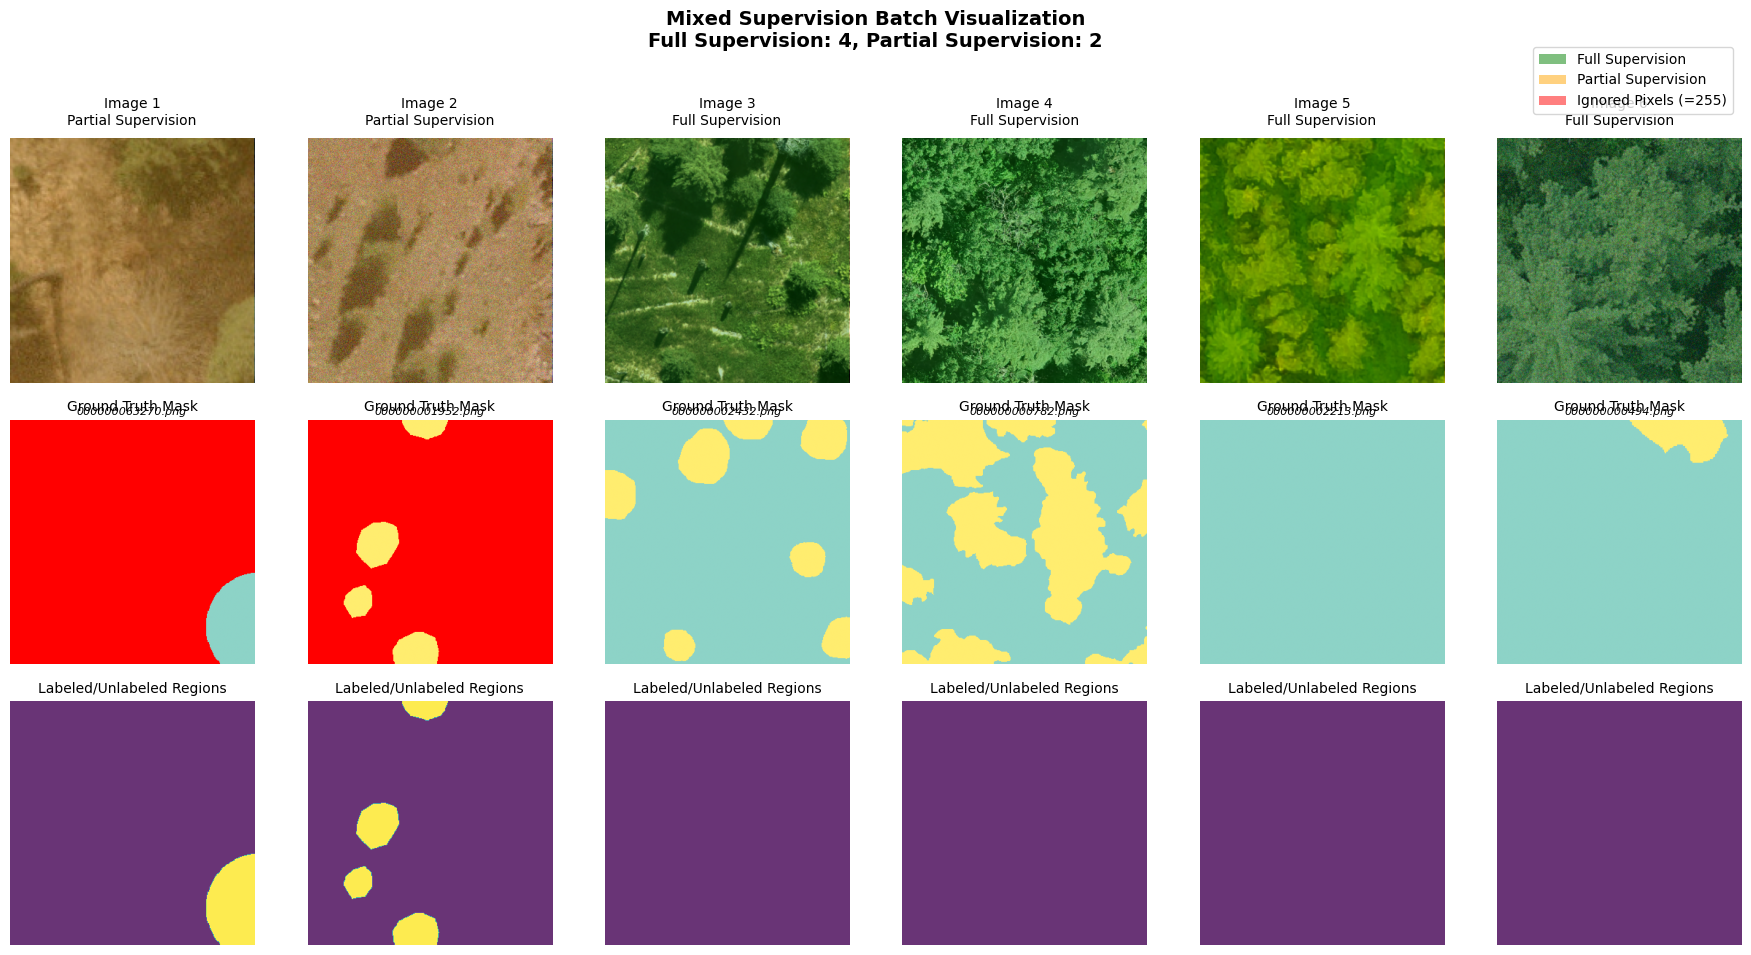

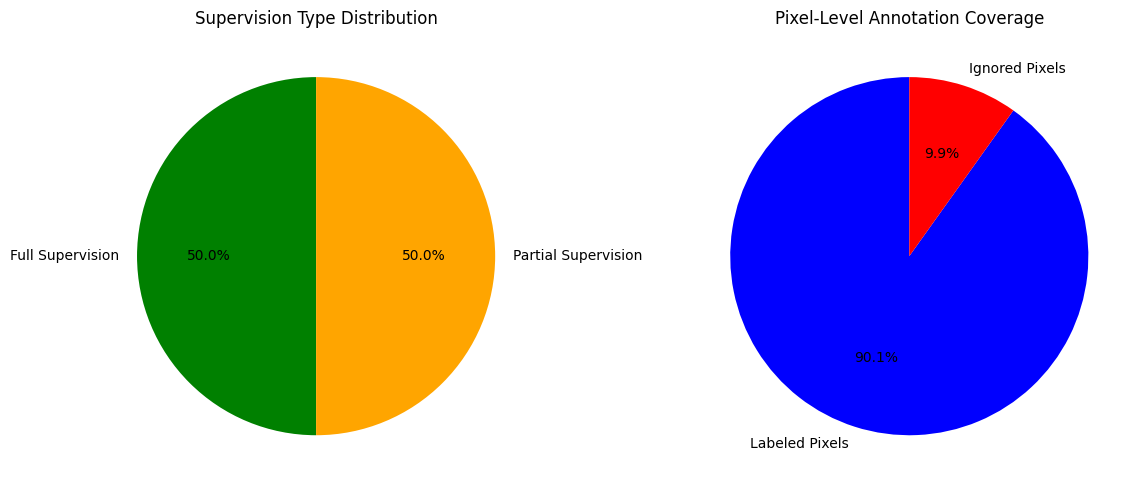

Batch Statistics:
  batch_size: 16
  image_shape: [16, 3, 336, 336]
  mask_shape: [16, 336, 336]
  full_supervision_count: 8
  partial_supervision_count: 8
  image_stats: {'min_value': 0.0, 'max_value': 1.0, 'mean_value': 0.30512911081314087, 'std_value': 0.23514138162136078}
  mask_stats: {'unique_values': [0, 1, 2, 3, 6, 7, 9, 10, 12, 14, 17, 20, 21, 25, 26, 36, 49, 59, 255], 'num_classes': 19, 'class_distribution': {0: 402483, 1: 1179, 2: 6393, 3: 45754, 6: 56504, 7: 47796, 9: 10106, 10: 198, 12: 54472, 14: 122839, 17: 41075, 20: 29626, 21: 58262, 25: 12686, 26: 1261, 36: 997, 49: 16770, 59: 22089, 255: 875846}}


In [7]:
print("TRAIN BATCH")

batch = next(iter(train_dataloader))

# 3. Plot the batch
fig = plot_mixed_supervision_batch(
    batch, 
    num_samples=6,
    save_path="mixed_supervision_batch.png",
    class_names=["Background", "Foreground"],
    figsize=(18, 10)
)
plt.show()

# 4. Plot supervision statistics
stats_fig = plot_supervision_statistics(batch)
plt.show()


stats = analyze_batch_details(batch)
print("Batch Statistics:")
for key, value in stats.items():
    print(f"  {key}: {value}")




VAL BATCH
Figure saved to: mixed_supervision_batch.png


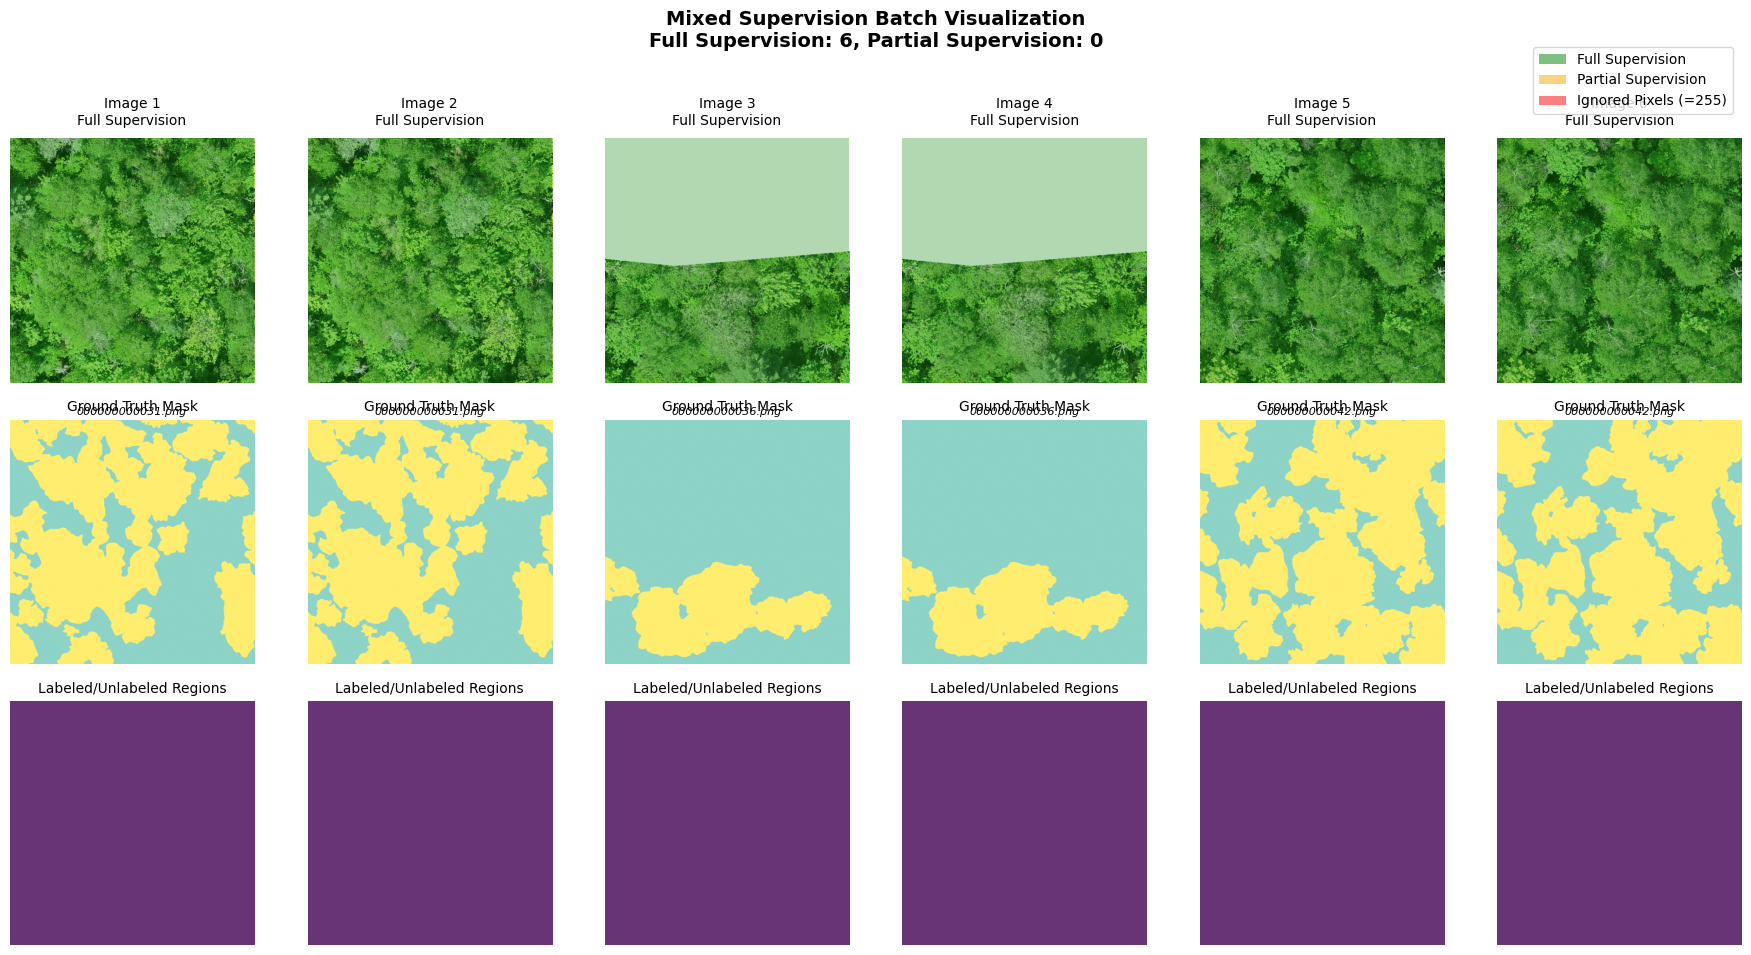

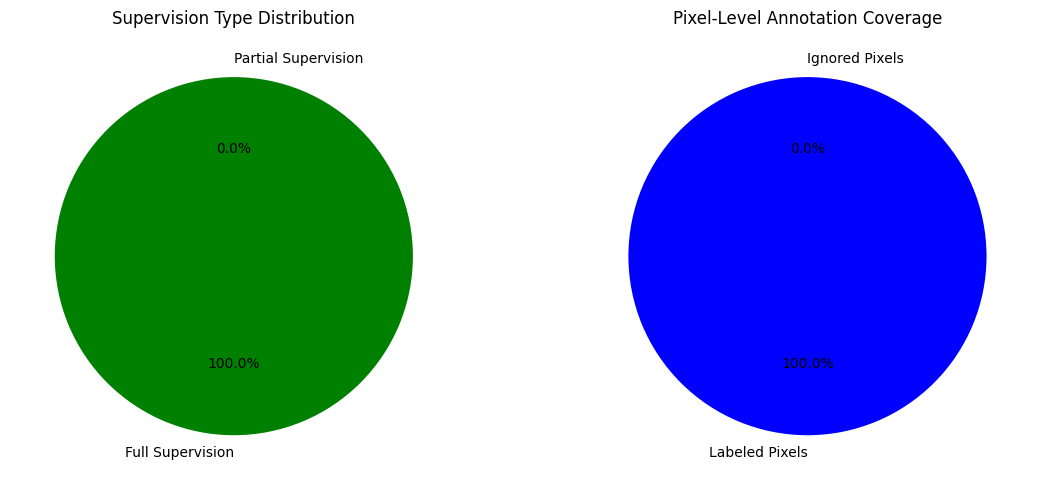

Batch Statistics:
  batch_size: 16
  image_shape: [16, 3, 640, 640]
  mask_shape: [16, 640, 640]
  full_supervision_count: 16
  partial_supervision_count: 0
  image_stats: {'min_value': 0.0, 'max_value': 1.0, 'mean_value': 0.43428197503089905, 'std_value': 0.27225881814956665}
  mask_stats: {'unique_values': [0, 1, 2, 4, 5, 7, 8, 10, 11, 13, 14, 15, 19, 22, 37, 45, 46, 60], 'num_classes': 18, 'class_distribution': {0: 1900638, 1: 2254042, 2: 1041956, 4: 126402, 5: 41864, 7: 272642, 8: 197144, 10: 76692, 11: 159786, 13: 14224, 14: 262244, 15: 58898, 19: 11990, 22: 44706, 37: 23814, 45: 29430, 46: 15326, 60: 21802}}


In [8]:
print("VAL BATCH")

batch = next(iter(val_dataloader))

# 3. Plot the batch
fig = plot_mixed_supervision_batch(
    batch, 
    num_samples=6,
    save_path="mixed_supervision_batch.png",
    class_names=["Background", "Foreground"],
    figsize=(18, 10)
)
plt.show()

# 4. Plot supervision statistics
stats_fig = plot_supervision_statistics(batch)
plt.show()


stats = analyze_batch_details(batch)
print("Batch Statistics:")
for key, value in stats.items():
    print(f"  {key}: {value}")




In [9]:
# Create callbacks
from pytorch_lightning.callbacks import RichProgressBar, ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger


checkpoint_callback = ModelCheckpoint(
    dirpath="treeai_checkpoints",
    filename="pasi-tree-ai-336-{epoch:02d}-{val_total_loss:.4f}",
    save_top_k=3,
    mode="min",
    save_last=True,
    monitor = "val_total_loss"
)

lr_monitor = LearningRateMonitor(logging_interval="step")
# Create logger (you can use either WandbLogger or TensorBoardLogger)
# Comment out if you don't want to use wandb

wandb_logger = WandbLogger(project="TreeAI-Segmentation", log_model=False)

# Create trainer
trainer = pl.Trainer(
    max_epochs=args["epochs"],
    accelerator="cuda",  # Uses GPU if available
    devices=1,
    callbacks=[checkpoint_callback, lr_monitor, RichProgressBar()],
    logger=wandb_logger,  # Comment out if not using wandb
    check_val_every_n_epoch=10,  # Only validate every 5 epochs
    gradient_clip_algorithm="norm",
    log_every_n_steps = 10,
    
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
# Train the model
import time
import datetime

# Start the timer
start_time = time.time()


trainer.fit(pl_model, train_dataloader, val_dataloader)
import wandb
wandb.finish()

# Calculate duration
end_time = time.time()
duration_seconds = end_time - start_time
duration_ms = duration_seconds * 1000

# Format as a readable duration
formatted_duration = str(datetime.timedelta(seconds=int(duration_seconds)))

# Print results
print(f"Training completed in: {formatted_duration} (H:M:S)")
print(f"Total seconds: {duration_seconds:.2f} s")
print(f"Total milliseconds: {duration_ms:.2f} ms")

wandb: Currently logged in as: jurriandoornbos (jurrain-phd) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\judoj\Documents\programming\multi_ssl\notebooks\treeai_checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃    ┃ Name                  ┃ Type                          ┃ Params ┃ Mode  ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0  │ backbone              │ MSRGBConvNeXtFeatureExtractor │ 29.9 M │ train │
│ 1  │ decode_head           │ UPerNetHead                   │  3.9 M │ train │
│ 2  │ criterion             │ CrossEntropyLoss              │      0 │ train │
│ 3  │ train_accuracy        │ MulticlassAccuracy            │      0 │ train │
│ 4  │ val_accuracy          │ MulticlassAccuracy            │      0 │ train │
│ 5  │ val_iou               │ MulticlassJaccardIndex        │      0 │ train │
│ 6  │ val_f1                │ MulticlassF1Score             │      0 │ train │
│ 7  │ val_per_class_iou     │ MulticlassJaccardIndex        │      0 │ train │
│ 8  │ val_per_class_f1      │ MulticlassF1Score             │      0 │ train │
│ 9  │ full_criterion        │ FocalLoss                     │      0 │ train │
│ 10 │ partial_criterion     │ FocalLoss                     │      0 │ train │
│ 11 │ consistency_criterion │ KLDivLoss                     │      0 │ train │
└────┴───────────────────────┴───────────────────────────────┴────────┴───────┘

Trainable params: 3.9 M                                                                                            
Non-trainable params: 29.9 M                                                                                       
Total params: 33.8 M                                                                                               
Total estimated model params size (MB): 135                                                                        
Modules in train mode: 412                                                                                         
Modules in eval mode: 0

Output()

C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer 
the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use 
`self.log(..., batch_size=batch_size)`.

C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer 
the `batch_size` from an ambiguous collection. The batch size we found is 8. To avoid any miscalculations, use 
`self.log(..., batch_size=batch_size)`.

C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch 
parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use 
`scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form 
is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate 
your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)

C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer 
the `batch_size` from an ambiguous collection. The batch size we found is 6. To avoid any miscalculations, use 
`self.log(..., batch_size=batch_size)`.

In [ ]:
# step 2: Load the trained 336 model from file and Train on 640 augmented for 10 epochs.
